# Library Imports

In [1]:
# Importing essential libraries and modules for data manipulation, visualization, and machine learning modeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from scipy.stats import uniform, randint
import joblib
import seaborn as sns

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time


# Data Preprocessing:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Sl.no                              103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

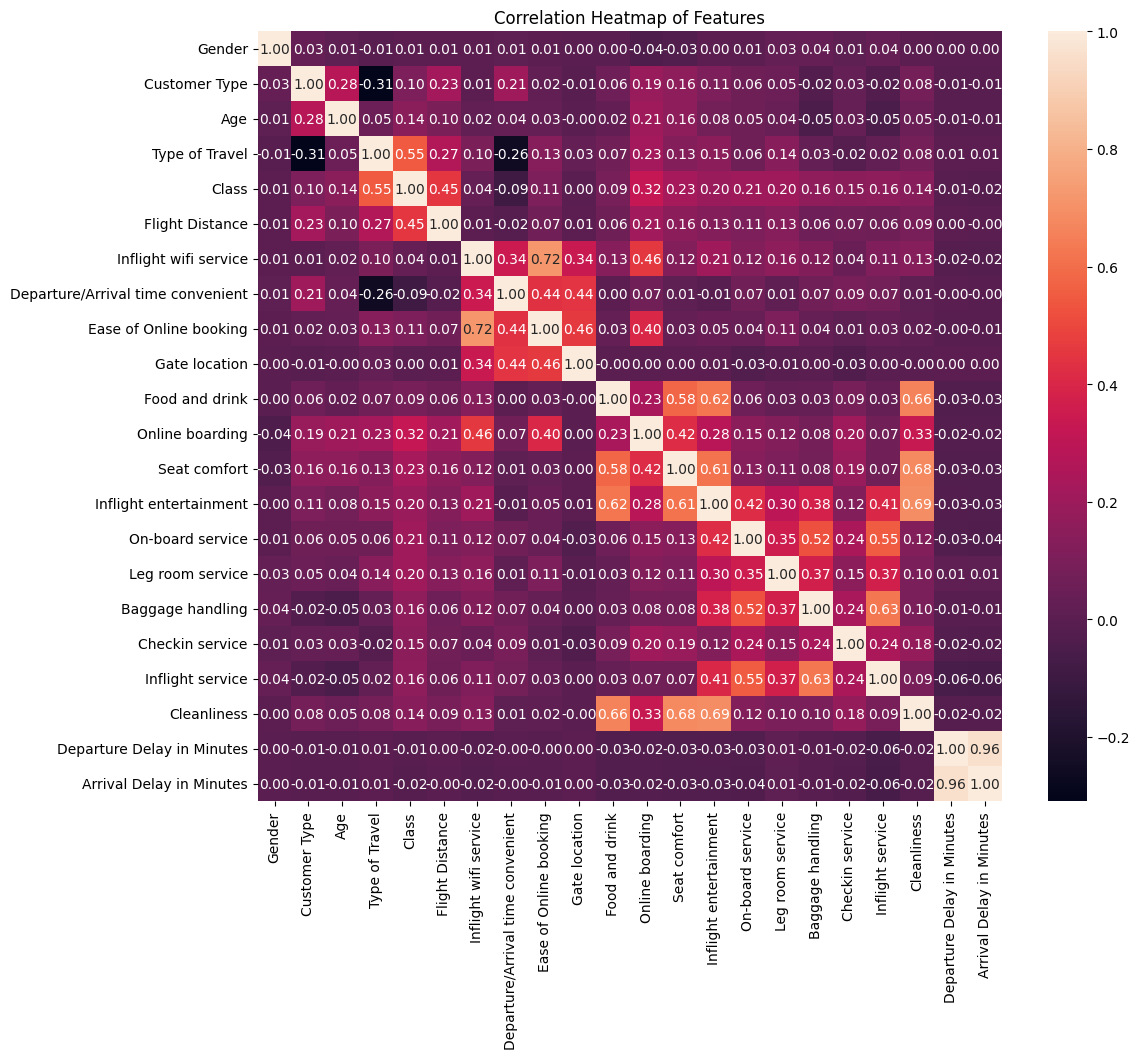

In [3]:
# Importing and examining the dataset
dataset = pd.read_csv("/content/drive/MyDrive/DBS/Data Mining /CA_1/train.csv")
pd.set_option('display.max_columns', None)
print(dataset.info())  # Display dataset information

# Check for missing values in the dataset
missing_values = dataset.isnull().sum()
missing_values = missing_values[missing_values > 0]
if not missing_values.empty:
    print("Missing values in the dataset:")
    print(missing_values)
else:
    print("No missing values found in the dataset.")

# Convert categorical features into numerical features
dataset['Gender'] = dataset['Gender'].map({'Male': 1, 'Female': 0})
dataset['Customer Type'] = dataset['Customer Type'].map({'Loyal Customer': 1, 'disloyal Customer': 0})
dataset['Type of Travel'] = dataset['Type of Travel'].map({'Business travel': 1, 'Personal Travel': 0})
dataset['Class'] = dataset['Class'].map({'Eco': 0, 'Eco Plus': 1, 'Business': 2})
dataset['satisfaction'] = dataset['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0}) #Target Variable

# Drop unnecessary columns
dataset = dataset.drop(['Sl.no', 'id'], axis=1)

# Divide dataset into features (X) and target label (Y)
X = dataset.drop('satisfaction', axis=1)
Y = dataset['satisfaction']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # we divied datainto 80-20 as train and Test

# Identifying numerical columns in the training set
numerical_columns_train = X_train.select_dtypes(include=np.number).columns

# Initializing and applying StandardScaler
scaler = StandardScaler()
X_train[numerical_columns_train] = scaler.fit_transform(X_train[numerical_columns_train])
X_test[numerical_columns_train] = scaler.transform(X_test[numerical_columns_train]) #applying transform at this section  to maintain consistent data processing

# Initializing and applying SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train[numerical_columns_train] = imputer.fit_transform(X_train[numerical_columns_train])
X_test[numerical_columns_train] = imputer.transform(X_test[numerical_columns_train]) #applying transform at this section to transform to maintain consistent data processing

# Output the shapes of the datasets and check for missing values
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Any missing values in training set: {np.any(np.isnan(X_train))}")
print(f"Any missing values in test set: {np.any(np.isnan(X_test))}")

plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# Modeling - Logistic Regression:

Confusion Matrix:
[[10293  1420]
 [ 1283  7785]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     11713
           1       0.85      0.86      0.85      9068

    accuracy                           0.87     20781
   macro avg       0.87      0.87      0.87     20781
weighted avg       0.87      0.87      0.87     20781

Accuracy: 0.87
ROC AUC: 0.93


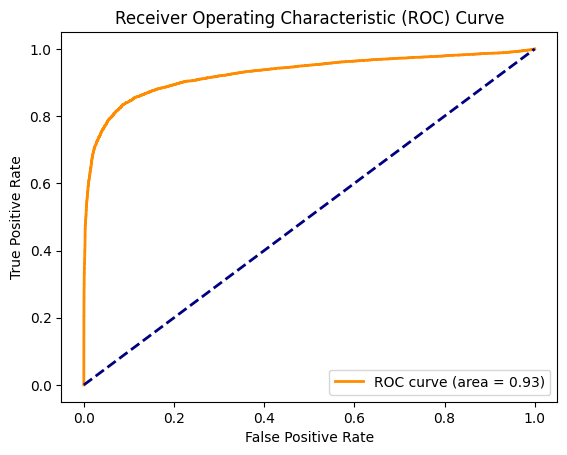

In [ ]:
# Creating a pipeline with SMOTE and Logistic Regression for handling class imbalance
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000))
])

# Define a  hyperparameter grid
param_grid = {
    'logreg__C': np.logspace(-2, 2, 5)
}

# Initialize GridSearchCV with CV folds and parallel processing
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Predict on the test set
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Modeling - Random Forest Classifier

Confusion Matrix:
[[11457   256]
 [  516  8552]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11713
           1       0.97      0.94      0.96      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781

Accuracy: 0.96
ROC AUC: 0.99


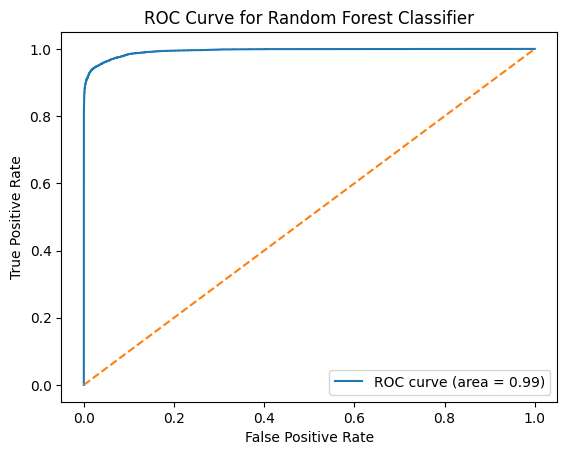

In [ ]:

# Create a pipeline with SMOTE and Random Forest Classifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()



# Modeling - SVC

Confusion Matrix:
[[11028   685]
 [ 1012  8056]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     11713
           1       0.92      0.89      0.90      9068

    accuracy                           0.92     20781
   macro avg       0.92      0.91      0.92     20781
weighted avg       0.92      0.92      0.92     20781

Accuracy: 0.92
ROC AUC: 0.97


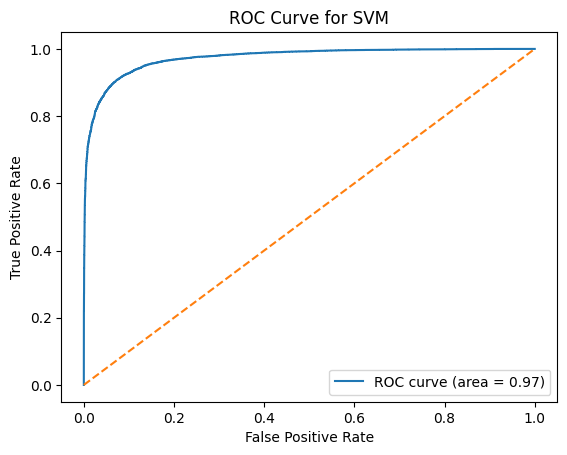

In [4]:

# Create a pipeline with SMOTE and SVM
pipeline = ImbPipeline([
    ('balancing', SMOTE(random_state=42)),
    ('classification', SVC(random_state=42, probability=True))  # Ensure probability=True for ROC AUC
])

# Define hyperparameters for grid search
param_grid = {
     'classification__C': [0.1, 1, 10],
    'classification__kernel': ['linear'], #based on the test run from linear,poly,rbf,sigmoid , Linear performed well
    'classification__gamma': ['scale', 'auto', 0.1, 1],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC')
plt.legend(loc='lower right')
plt.show()


# Modeling - AdaBoost

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Confusion Matrix:
[[10991   722]
 [  746  8322]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11713
           1       0.92      0.92      0.92      9068

    accuracy                           0.93     20781
   macro avg       0.93      0.93      0.93     20781
weighted avg       0.93      0.93      0.93     20781

Accuracy: 0.93
ROC AUC: 0.98


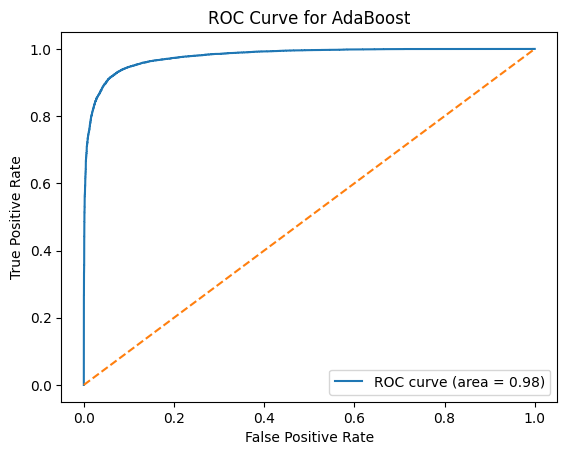

In [ ]:
# Create a pipeline with SMOTE and AdaBoost
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'adaboost__n_estimators': [50, 100, 200],
    'adaboost__learning_rate': [0.01, 0.1, 1]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Predict on the test set
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AdaBoost')
plt.legend(loc='lower right')
plt.show()


# Modeling - XGBoost classifier

Grid Search Progress:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting 5 folds for each of 64 candidates, totalling 320 fits


Grid Search Progress:   2%|▏         | 1/60 [06:40<6:33:23, 400.07s/it]


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Accuracy: 0.96
ROC AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     11713
           1       0.97      0.94      0.95      9068

    accuracy                           0.96     20781
   macro avg       0.96      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781

Confusion Matrix:
[[11456   257]
 [  575  8493]]


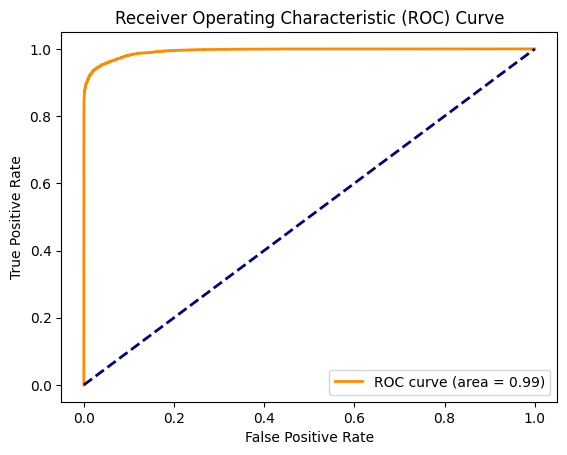

Time taken: 7.653236389160156e-05 seconds


In [5]:
# Define param_grid
param_grid = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [3, 4],
    'xgbclassifier__learning_rate': [0.01, 0.1],
    'xgbclassifier__subsample': [0.7, 1.0],
    'xgbclassifier__colsample_bytree': [0.6, 0.9],
    'xgbclassifier__gamma': [0, 0.5]
}

# Initialize XGBoost classifier and SMOTE
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
smote = SMOTE()

# Creating the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('xgbclassifier', xgb_classifier)
])

# Setting up GridSearchCV with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=5, n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator
best_pipeline = grid_search.best_estimator_

# Predictions
predictions = best_pipeline.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, best_pipeline.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, predictions))
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




# Model Comparison

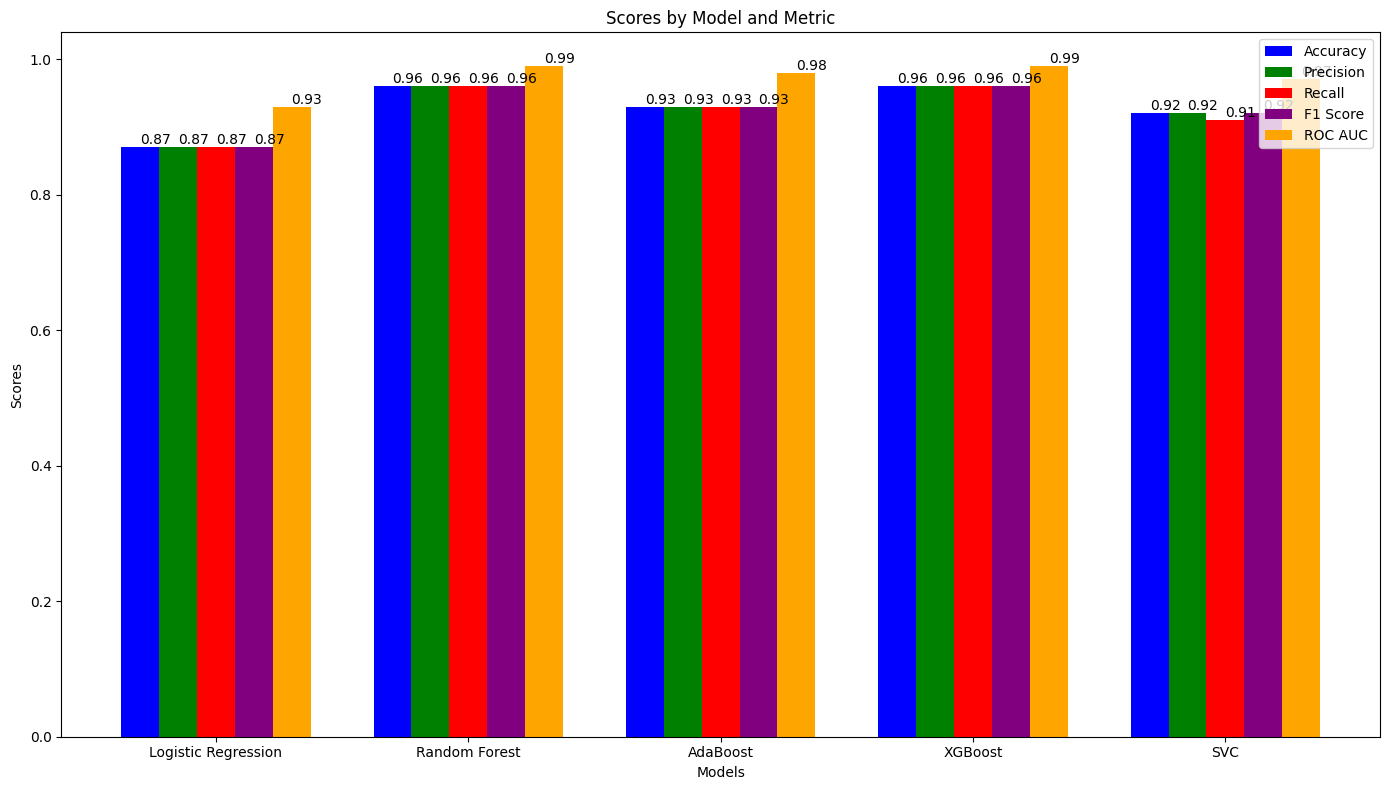

In [22]:
# Define the performance metrics for each model
models_performance = {
    'Model': ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'SVC'],
    'Accuracy': [0.87, 0.96, 0.93, 0.96, 0.92],
    'Precision': [0.87, 0.96, 0.93, 0.96, 0.92],  # Assuming the precision to be macro avg
    'Recall': [0.87, 0.96, 0.93, 0.96, 0.91],     # Assuming the recall to be macro avg
    'F1 Score': [0.87, 0.96, 0.93, 0.96, 0.92],   # Assuming the F1-score to be macro avg
    'ROC AUC': [0.93, 0.99, 0.98, 0.99, 0.97]
}
# Convert the dictionary to a DataFrame for easier plotting
performance_df = pd.DataFrame(models_performance)

# Number of groups and bar width
n_groups = len(performance_df)
bar_width = 0.15
index = np.arange(n_groups)

# Plotting the performance metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Create subplots
fig, ax = plt.subplots(figsize=(14, 8))

for i, metric in enumerate(metrics):
    bar_positions = index + i * bar_width
    bars = ax.bar(bar_positions, performance_df[metric], bar_width, label=metric, color=colors[i])

    # Add the data values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by Model and Metric')
ax.set_xticks(index + bar_width * 2)
ax.set_xticklabels(performance_df['Model'])
ax.legend()

# Show the plot with a tighter layout
plt.tight_layout()
plt.show()


**Confusion Matrices:**

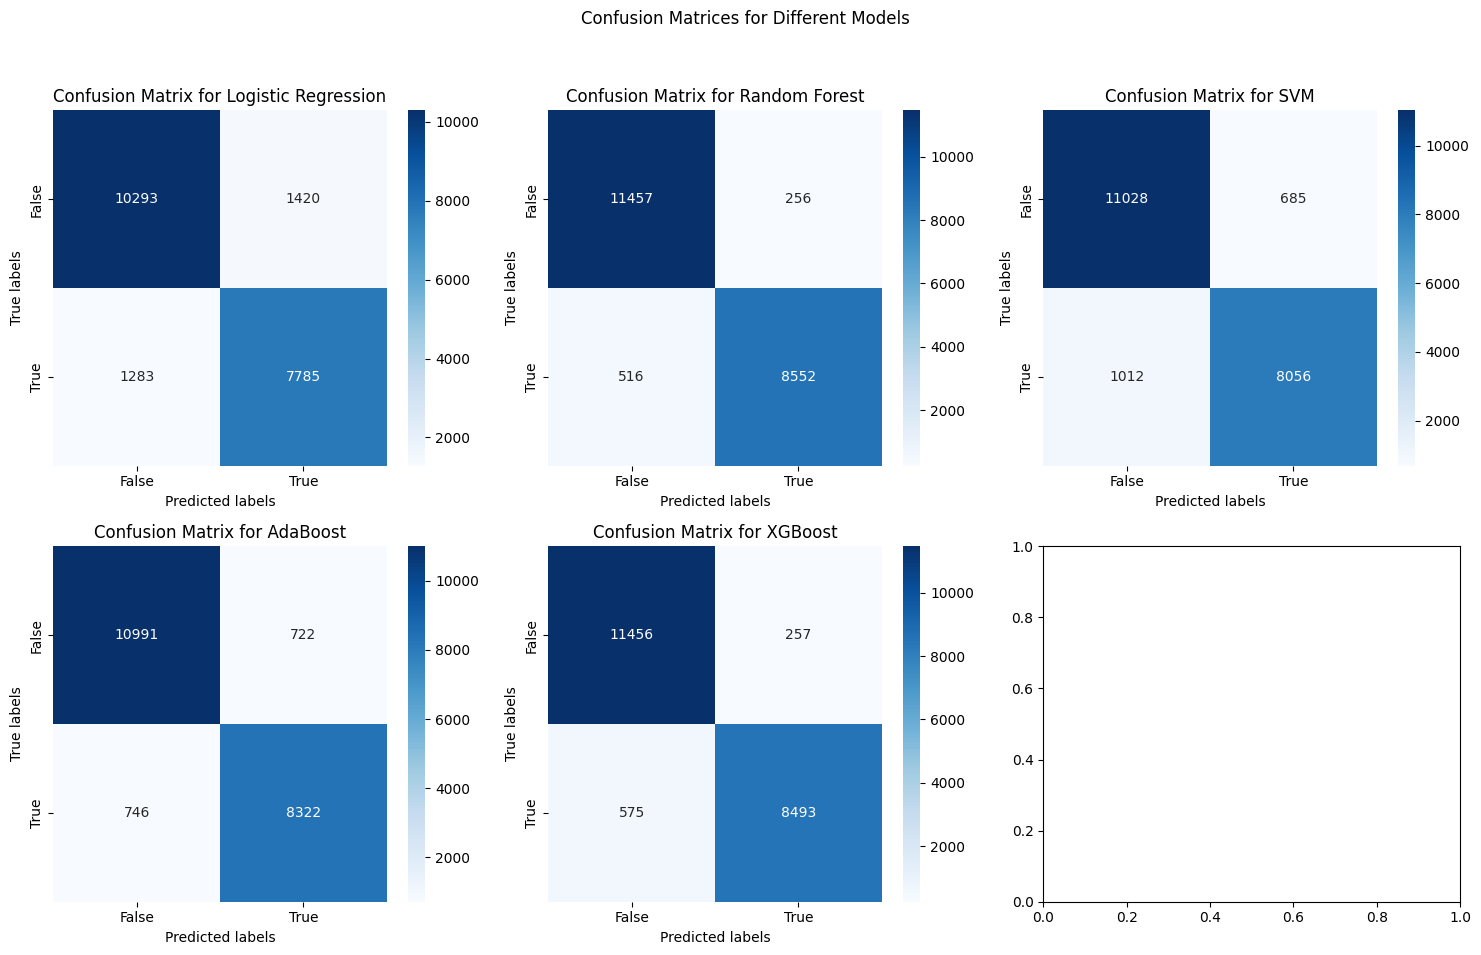

In [12]:
# Example confusion matrices for each model
confusion_matrices = {
    'Logistic Regression': [[10293, 1420], [1283, 7785]],
    'Random Forest': [[11457, 256], [516, 8552]],
    'SVM': [[11028, 685], [1012, 8056]],
    'AdaBoost': [[10991, 722], [746, 8322]],
    'XGBoost': [[11456, 257], [575, 8493]]

}
def plot_confusion_matrix(cm, model_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Confusion Matrices for Different Models')

for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    plot_confusion_matrix(np.array(cm), model_name, axes[i//3, i%3])

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Computation Time Analysis**

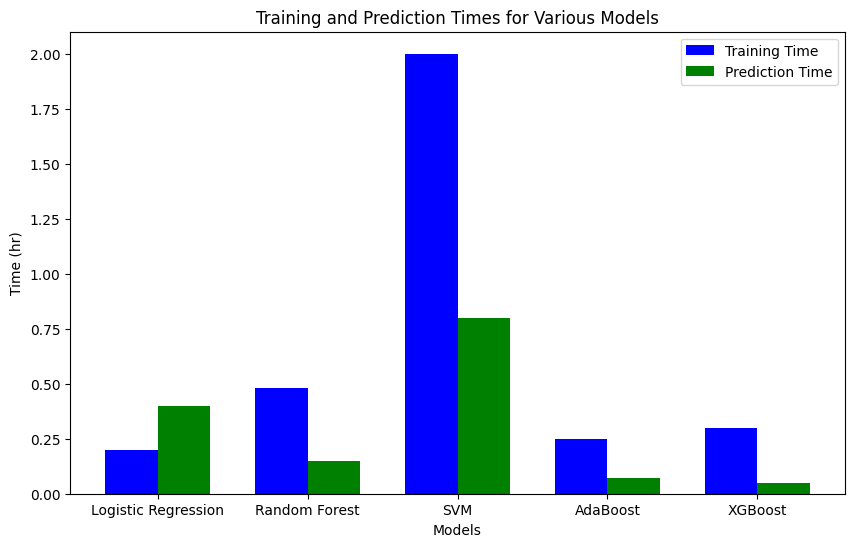

In [13]:
# Example data: model names and their respective training and prediction times
model_names = ['Logistic Regression', 'Random Forest', 'SVM','AdaBoost','XGBoost']
training_times = [0.20,0.48,2.00,0.25,0.30]  # In seconds
prediction_times = [0.4, 0.15, 0.80,0.07,0.05]  # In seconds

# Setting up the bar chart
bar_width = 0.35
index = range(len(model_names))

# Creating subplots for better layout
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the training times
training_bar = ax.bar(index, training_times, bar_width, label='Training Time', color='b')

# Plotting the prediction times
prediction_bar = ax.bar([p + bar_width for p in index], prediction_times, bar_width, label='Prediction Time', color='g')

# Adding labels and titles
ax.set_xlabel('Models')
ax.set_ylabel('Time (hr)')
ax.set_title('Training and Prediction Times for Various Models')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.show()


**Implementation Costs Analysis As Per Airline Industry Standards**

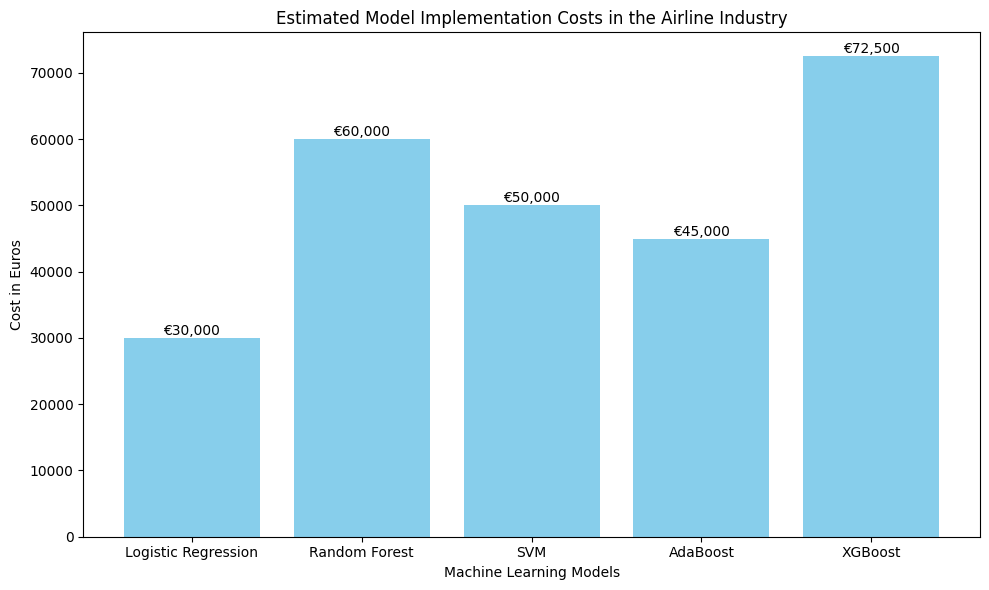

In [23]:
# Model names and their estimated implementation costs in euros
models = ['Logistic Regression', 'Random Forest', 'SVM', 'AdaBoost', 'XGBoost']
costs = [30000, 60000, 50000, 45000, 72500]  #  costs in euros as per the airline industry standards

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, costs, color='skyblue')

# Add a title and labels
plt.title('Estimated Model Implementation Costs in the Airline Industry')
plt.xlabel('Machine Learning Models')
plt.ylabel('Cost in Euros')

# Adding the data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'€{int(yval):,}', va='bottom', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()



# Cost Benefit Analysis

Net Benefit Analysis

Logistic Regression:
  Benefit of TP: $1557000
  Benefit of TN: $514650
  Cost of FP: $142000
  Cost of FN: $192450
  Net Benefit: $1737200

Random Forest:
  Benefit of TP: $1710400
  Benefit of TN: $572850
  Cost of FP: $25600
  Cost of FN: $77400
  Net Benefit: $2180250

AdaBoost:
  Benefit of TP: $1664400
  Benefit of TN: $549550
  Cost of FP: $72200
  Cost of FN: $111900
  Net Benefit: $2029850

XGBoost:
  Benefit of TP: $1698600
  Benefit of TN: $572800
  Cost of FP: $25700
  Cost of FN: $86250
  Net Benefit: $2159450

SVC:
  Benefit of TP: $1611200
  Benefit of TN: $551400
  Cost of FP: $68500
  Cost of FN: $151800
  Net Benefit: $1942300



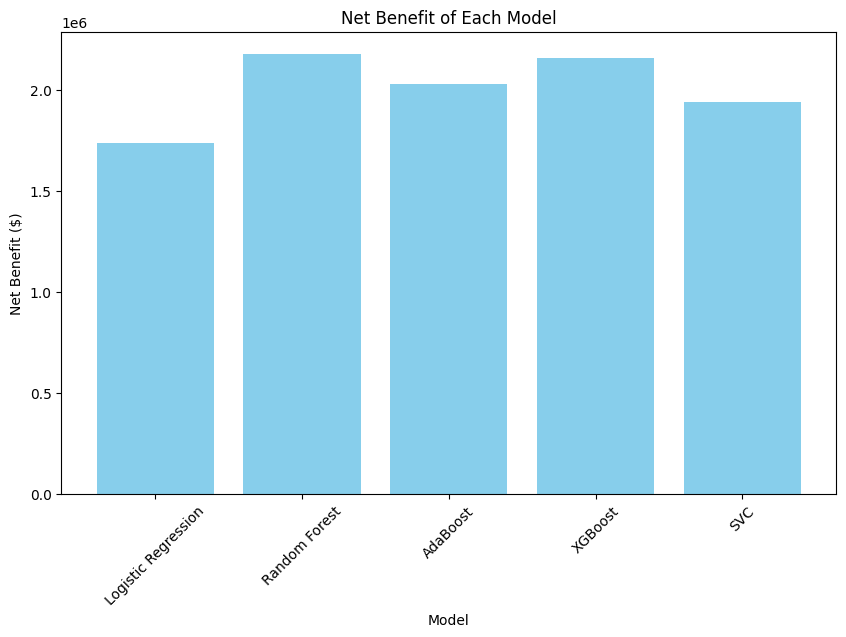

In [7]:
# Define the hypothecated cost-benefit parameters
cost_fp = 100  # Cost of a false positive
cost_fn = 150  # Cost of a false negative
benefit_tp = 200  # Benefit of a true positive
benefit_tn = 50  # Benefit of a true negative

# Confusion matrix values for each model
confusion_matrices = {
    "Logistic Regression": {"TP": 7785, "TN": 10293, "FP": 1420, "FN": 1283},
    "Random Forest": {"TP": 8552, "TN": 11457, "FP": 256, "FN": 516},
    "AdaBoost": {"TP": 8322, "TN": 10991, "FP": 722, "FN": 746},
    "XGBoost": {"TP": 8493, "TN": 11456, "FP": 257, "FN": 575},
    "SVC": {"TP": 8056, "TN": 11028, "FP": 685, "FN": 1012}
}

# Store model names and their net benefits for visualization
models = []
net_benefits = []

# Loop through each model to calculate and print costs/benefits and net benefit
for model, matrix in confusion_matrices.items():
    cost_benefit_tp = matrix["TP"] * benefit_tp
    cost_benefit_tn = matrix["TN"] * benefit_tn
    cost_benefit_fp = matrix["FP"] * cost_fp
    cost_benefit_fn = matrix["FN"] * cost_fn
    net_benefit = cost_benefit_tp + cost_benefit_tn - cost_benefit_fp - cost_benefit_fn

    print(f"{model}:")
    print(f"  Benefit of TP: ${cost_benefit_tp}")
    print(f"  Benefit of TN: ${cost_benefit_tn}")
    print(f"  Cost of FP: ${cost_benefit_fp}")
    print(f"  Cost of FN: ${cost_benefit_fn}")
    print(f"  Net Benefit: ${net_benefit}")
    print()

    # Append model name and its net benefit for visualization
    models.append(model)
    net_benefits.append(net_benefit)

# Creating a bar chart for the net benefits
plt.figure(figsize=(10, 6))
plt.bar(models, net_benefits, color='skyblue')

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Net Benefit ($)')
plt.title('Net Benefit of Each Model')
plt.xticks(rotation=45)

# Displaying the chart
plt.show()


Advance CBA

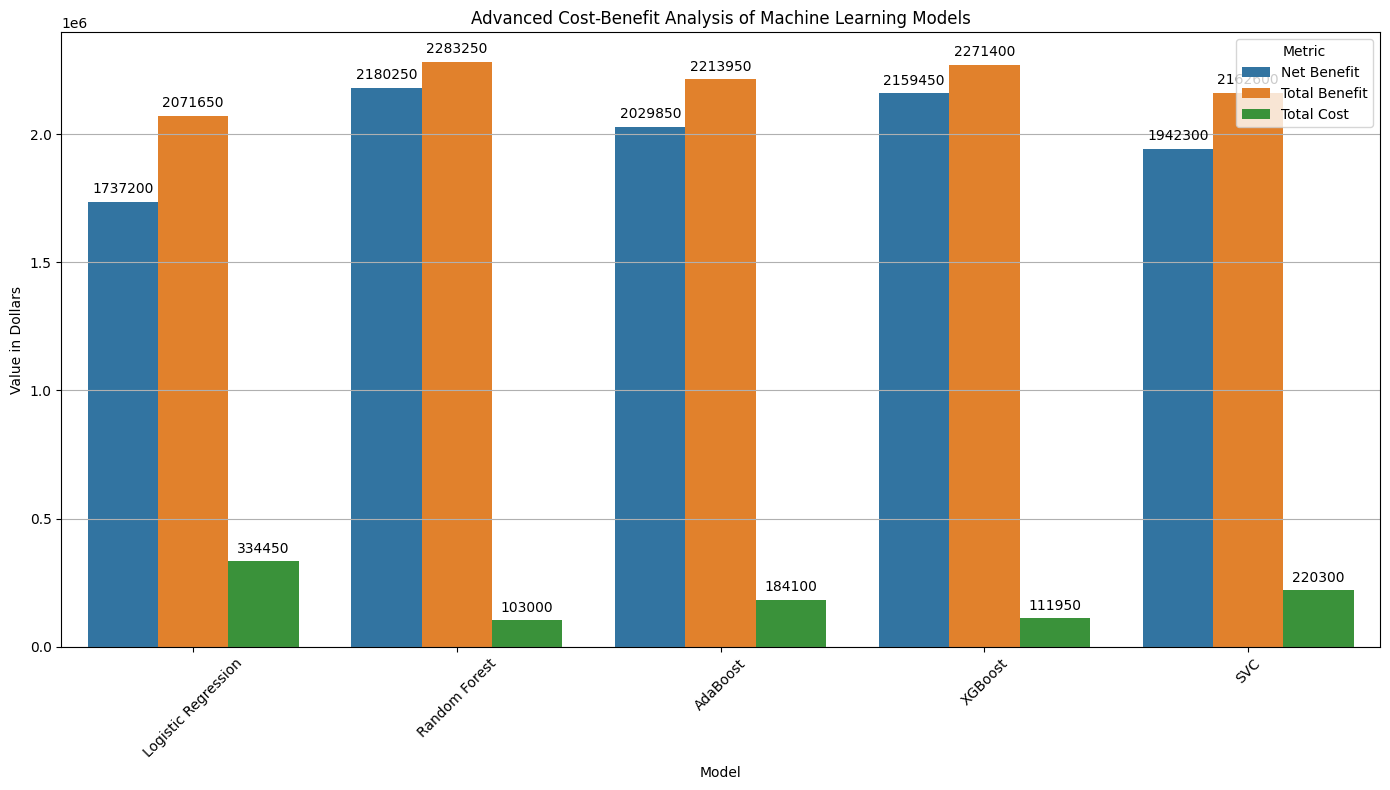

In [3]:
# Data for cost-benefit analysis
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'SVC'],
    'Net Benefit': [1737200, 2180250, 2029850, 2159450, 1942300],
    'Total Benefit': [2071650, 2283250, 2213950, 2271400, 2162600],
    'Total Cost': [334450, 103000, 184100, 111950, 220300]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

# Creating the advanced visualization
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)

# Adding annotations
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha = 'center', va = 'center',
                      xytext = (0, 9),
                      textcoords = 'offset points')

# Adding titles, labels, and grid
plt.title('Advanced Cost-Benefit Analysis of Machine Learning Models')
plt.xlabel('Model')
plt.ylabel('Value in Dollars')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Displaying the plot
plt.tight_layout()
plt.show()


Financial Impact of Model Predections

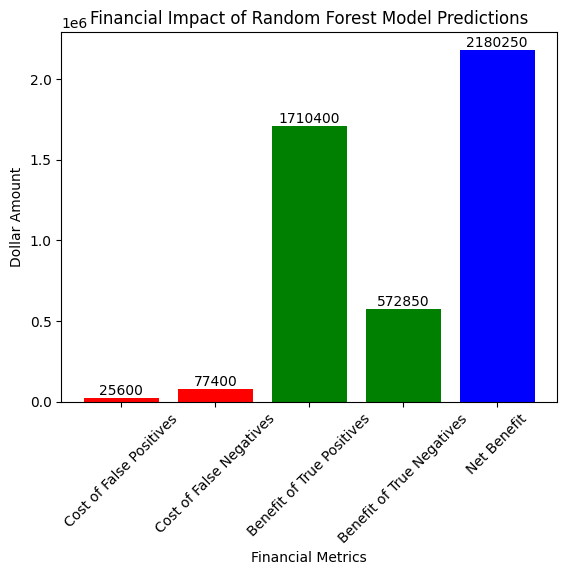

In [12]:
import matplotlib.pyplot as plt

# Cost-Benefit parameters
cost_fp = 100  # Cost of a false positive
cost_fn = 150  # Cost of a false negative
benefit_tp = 200  # Benefit of a true positive
benefit_tn = 50   # Benefit of a true negative

# Confusion matrix for Random Forest model
confusion_matrix_rf = {"TP": 8552, "TN": 11457, "FP": 256, "FN": 516}

# Calculating the financial impact
financial_impact_rf = {
    "Cost of False Positives": confusion_matrix_rf["FP"] * cost_fp,
    "Cost of False Negatives": confusion_matrix_rf["FN"] * cost_fn,
    "Benefit of True Positives": confusion_matrix_rf["TP"] * benefit_tp,
    "Benefit of True Negatives": confusion_matrix_rf["TN"] * benefit_tn
}

# Net benefit
net_benefit_rf = (financial_impact_rf["Benefit of True Positives"] +
                  financial_impact_rf["Benefit of True Negatives"] -
                  financial_impact_rf["Cost of False Positives"] -
                  financial_impact_rf["Cost of False Negatives"])

# Adding net benefit to the dictionary
financial_impact_rf["Net Benefit"] = net_benefit_rf

# Visualization
labels = list(financial_impact_rf.keys())
values = list(financial_impact_rf.values())



bars = plt.bar(labels, values, color=['red', 'red', 'green', 'green', 'blue'])
plt.xlabel('Financial Metrics')
plt.ylabel('Dollar Amount')
plt.title('Financial Impact of Random Forest Model Predictions')
plt.xticks(rotation=45)

# Adding the numbers on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()


# Testing Data with Pretrained  Models for better POV

XGB Model

In [ ]:
# Load test data
test_data_path = '/content/test - Copy.csv'
test_data = pd.read_csv(test_data_path)

# Load XGBoost model
model_path = '/content/xgb_model.pkl'

# Check if the model is loaded properly and is fitted
if not hasattr(XGBClassifier, 'get_booster'):
    raise ValueError("The loaded model does not seem to be fitted. Please load a trained model.")

# Predict on test data
predictions = XGBClassifier.predict(test_data)

# Save predictions to a CSV file
output_path = '/content/predictions.csv'
test_data['predictions'] = predictions
test_data.to_csv(output_path, index=False)

# Print predictions
print(predictions)


RM Model

In [ ]:
# Load test data
test_data_path = '/content/test - Copy.csv'
test_data = pd.read_csv(test_data_path)

# Load RM model
model_path = '/content/RM_model.pkl'

# Predict on test data
predictions = RandomForestClassifier.predict(test_data)

# Save predictions to a CSV file
output_path = '/content/RM_predictions.csv'
test_data['predictions'] = predictions
test_data.to_csv(output_path, index=False)

# Print predictions
print(predictions)
